<a href="https://colab.research.google.com/github/yyqbb/DATA301-Project/blob/main/clothing_reviews_cluster-analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This is a seperate noteboook for my project dedicated solely to clustering analysis

In [ ]:
import dask.bag as db
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import json
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

# Specify the path to the saved files in Google Drive
input_path = '/content/drive/MyDrive/processed_data.json'

# Load the processed data from Google Drive
data_bag = db.read_text(input_path).map(json.loads)
data_bag.take(5)

Mounted at /content/drive


({'body type': 'hourglass',
  'rating': '10',
  'review_text': "An adorable romper! Belt and zipper were a little hard to navigate in a full day of wear/bathroom use, but that's to be expected. Wish it had pockets, but other than that-- absolutely perfect! I got a million compliments.",
  'fit': 'fit'},
 {'body type': 'straight & narrow',
  'rating': '10',
  'review_text': 'I rented this dress for a photo shoot. The theme was "Hollywood Glam and Big Beautiful Hats". The dress was very comfortable and easy to move around in. It is definitely on my list to rent again for another formal event. ',
  'fit': 'fit'},
 {'body type': 'pear',
  'rating': '8',
  'review_text': "I rented this for my company's black tie awards banquet.  I liked that this dress was short but was a little fancier with the sequins. (I generally don't care for long dresses.)  I would describe the color as more rose gold than yellow gold.  I have blonde hair and fair skin, and the color was very flattering.  This is a v

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster Centers (in original scale):
   body type_apple  body type_athletic  body type_full bust  \
0         0.030608            0.251615             0.090260   
1         0.026600            0.247490             0.082148   
2         0.028855            0.227718             0.090775   

   body type_hourglass  body type_pear  body type_petite  \
0             0.308101        0.118504          0.117744   
1             0.311407        0.123043          0.125431   
2             0.311855        0.138375          0.125488   

   body type_straight & narrow       fit_fit     fit_large     fit_small  \
0                     0.083168 -1.117995e-13 -3.191891e-15  1.000000e+00   
1                     0.083880  1.000000e+00 -1.189326e-13 -2.117750e-14   
2                     0.076933 -1.109113e-13  1.000000e+00 -7.271961e-15   

     rating  
0  8.404863  
1  9.299240  
2  8.543608  


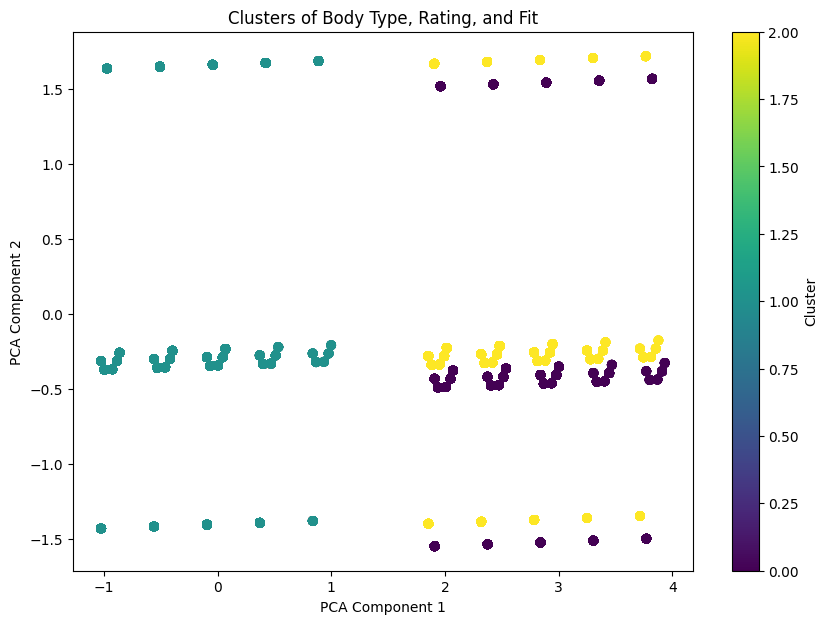

In [ ]:
def preprocess_data(input_path):
    # Load the processed data from Google Drive
    data_bag = db.read_text(input_path).map(json.loads)
    # Convert Dask bag to Dask DataFrame
    df = data_bag.to_dataframe()
    # Convert Dask DataFrame to Pandas DataFrame
    df = df.compute()
    # Select relevant features for clustering and drop rows with missing values
    features = df[['body type', 'rating', 'fit']].dropna()
    # One-hot encode the categorical variables ('body type' and 'fit')
    encoder = OneHotEncoder(sparse=False)
    encoded_features = encoder.fit_transform(features[['body type', 'fit']])
    # Combine the encoded features with the 'rating' column
    features_combined = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['body type', 'fit']))
    features_combined['rating'] = features['rating'].values

    return features_combined

def cluster_data(features_combined, n_clusters=3):
    # Standardize the features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features_combined)
    # Perform K-Means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(scaled_features)
    # Add the cluster labels to the DataFrame
    features_combined['cluster'] = kmeans.labels_
    # Reduce dimensions for visualization using PCA
    pca = PCA(n_components=2)
    pca_features = pca.fit_transform(scaled_features)
    # Add PCA components to the DataFrame for visualization
    features_combined['PCA1'] = pca_features[:, 0]
    features_combined['PCA2'] = pca_features[:, 1]
    # Print the cluster centers
    cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
    print("Cluster Centers (in original scale):")
    print(pd.DataFrame(cluster_centers, columns=features_combined.columns[:-3]))

    return features_combined

if __name__ == "__main__":
    # Preprocess data
    features_combined = preprocess_data(input_path)
    # Cluster data
    clustered_data = cluster_data(features_combined)

    # Visualize the clusters
    plt.figure(figsize=(10, 7))
    plt.scatter(clustered_data['PCA1'], clustered_data['PCA2'], c=clustered_data['cluster'], cmap='viridis')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title('Clusters of Body Type, Rating, and Fit')
    plt.colorbar(label='Cluster')
    plt.show()

In [ ]:
# Melt the DataFrame to long format for plotting
melted_features = pd.melt(features_combined,
                          id_vars=['rating', 'cluster', 'PCA1', 'PCA2'],
                          value_vars=[col for col in features_combined.columns if col.startswith('body type_')],
                          var_name='body type', value_name='presence')

# Filter to include only rows where 'presence' is 1
melted_features = melted_features[melted_features['presence'] == 1]

# Remove the 'presence' column
melted_features = melted_features.drop(columns=['presence'])

# Adjust body type names for better readability
melted_features['body type'] = melted_features['body type'].str.replace('body type_', '').str.replace('_', ' & ')


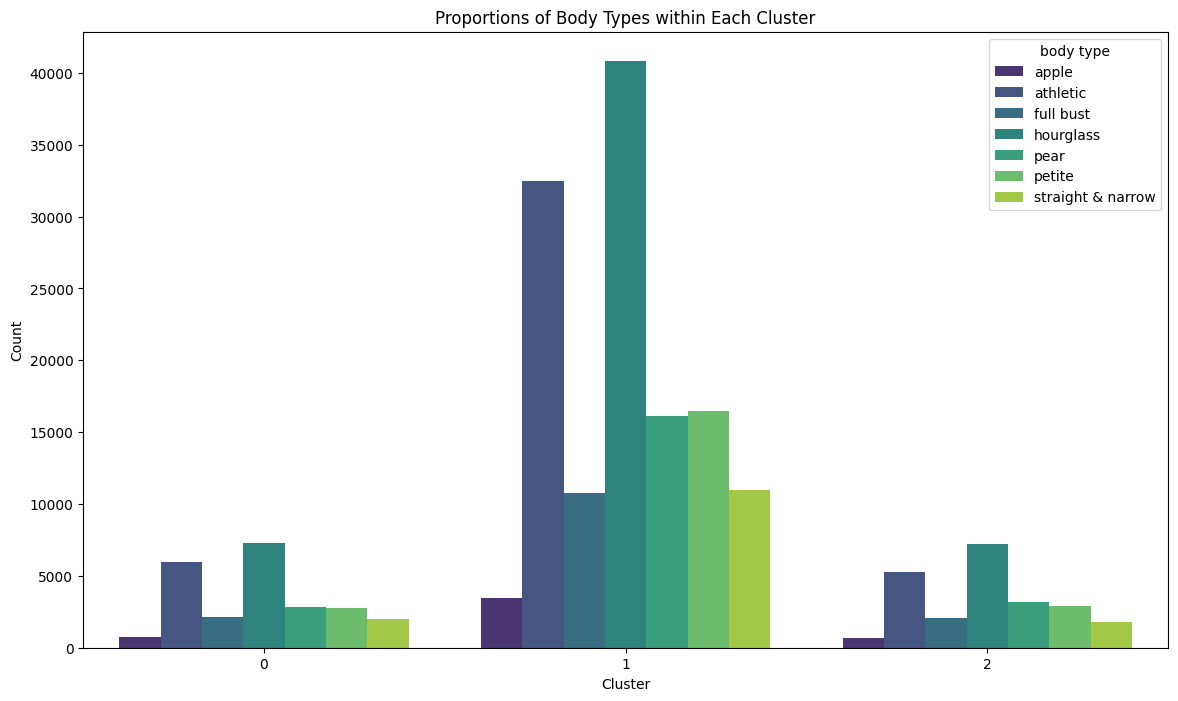

In [ ]:
# Plot proportions of body types within each cluster
plt.figure(figsize=(14, 8))
sns.countplot(x='cluster', hue='body type', data=melted_features, palette='viridis')
plt.title('Proportions of Body Types within Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()
